In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer
import torch

In [2]:
epochs = 10000

# Iris dataset

In [3]:
# Loading the data
iris = load_iris()  # Load data from sklearn
X = iris.data
y = iris.target

# Splitting in train/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale the data to 0 mean and 1 variance
scaler = StandardScaler()
scaler.fit(X_train)     # We fit it on X_train, the data "we can see"
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Enforce the type of the data
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).long()
y_test = torch.tensor(y_test).long()

# CPU training

## Definition

In [4]:
model_cpu = torch.nn.Sequential(
    torch.nn.Linear(4, 256),     # 4 inputs
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 3),     # 3 outputs, one for each possible category
    torch.nn.Softmax(dim=1)
    )

optimizer_cpu = torch.optim.SGD(model_cpu.parameters(), lr=1e-4, momentum=0.9)

In [5]:
loss_fn = torch.nn.CrossEntropyLoss()

## Training

In [6]:
def train(X_train, X_test, y_train, y_test,
          model, optimizer, loss_fn, epochs):
    
    accuracy_train_list = []
    accuracy_test_list = []
    t_list = []
    
    t_start = timer()
    
    for i in range(epochs):
        
        # Our classic syntax to update the weights
        
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Determining the error
        
        with torch.no_grad():

            # Train accuracy
            y_pred = model(X_train)  # Make prediction for the test dataset
            correct = \
                (torch.argmax(y_pred, dim=1) == y_train).type(torch.FloatTensor)
            accuracy_train_list.append(correct.mean())

            # Test accuracy
            y_pred = model(X_test)  # Make prediction for the train dataset
            correct = \
                (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
            accuracy_test_list.append(correct.mean())
    
        t_end = timer()
        t_list.append(t_end - t_start)
        
        if i % 1000 == 0:
            print('[{} / {}]\tTrain: {:.2%}, test: {:.2%}' \
                  .format(i, epochs, accuracy_test_list[-1], accuracy_train_list[-1]))
    
    return accuracy_train_list, accuracy_test_list, t_list

In [7]:
acc_train_cpu, acc_test_cpu, t_list_cpu = \
    train(X_train, X_test, y_train, y_test,
          model_cpu, optimizer_cpu, loss_fn, epochs)

[0 / 10000] Train: 43.33% (%),	Test: 30.83% (%)
[1000 / 10000] Train: 53.33% (%),	Test: 70.83% (%)
[2000 / 10000] Train: 60.00% (%),	Test: 74.17% (%)
[3000 / 10000] Train: 73.33% (%),	Test: 83.33% (%)
[4000 / 10000] Train: 80.00% (%),	Test: 85.00% (%)
[5000 / 10000] Train: 83.33% (%),	Test: 86.67% (%)
[6000 / 10000] Train: 86.67% (%),	Test: 87.50% (%)
[7000 / 10000] Train: 86.67% (%),	Test: 89.17% (%)
[8000 / 10000] Train: 90.00% (%),	Test: 89.17% (%)
[9000 / 10000] Train: 93.33% (%),	Test: 90.83% (%)


In [8]:
print("Accuracy:\tTrain: {:.2%},\tTest: {:.2%}".format(acc_train_cpu[-1], acc_test_cpu[-1]))
print("Training time on cpu: {:.1f} (s)".format(t_list_cpu[-1]))

Accuracy:	Train: 91.67%,	Test: 93.33%
Training time on cpu: 46.1 (s)


# GPU training

## Enable the GPU

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [10]:
X_train_gpu = X_train.to(device)
X_test_gpu = X_test.to(device)
y_train_gpu = y_train.to(device)
y_test_gpu = y_test.to(device)

In [11]:
model_gpu = model_cpu = torch.nn.Sequential(
    torch.nn.Linear(4, 256),     # 4 inputs
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 3),     # 3 outputs, one for each possible category
    torch.nn.Softmax(dim=1)
    )

In [12]:
model_gpu = model_gpu.to(device)

In [13]:
optimizer_gpu = torch.optim.SGD(model_gpu.parameters(), lr=1e-4, momentum=0.9)

## Training

In [14]:
acc_train_gpu, acc_test_gpu, t_list_gpu = \
    train(X_train_gpu, X_test_gpu, y_train_gpu, y_test_gpu,
          model_gpu, optimizer_gpu, loss_fn, epochs)

[0 / 10000] Train: 20.00% (%),	Test: 17.50% (%)
[1000 / 10000] Train: 56.67% (%),	Test: 69.17% (%)
[2000 / 10000] Train: 66.67% (%),	Test: 73.33% (%)
[3000 / 10000] Train: 73.33% (%),	Test: 83.33% (%)
[4000 / 10000] Train: 83.33% (%),	Test: 85.83% (%)
[5000 / 10000] Train: 86.67% (%),	Test: 90.00% (%)
[6000 / 10000] Train: 90.00% (%),	Test: 90.00% (%)
[7000 / 10000] Train: 90.00% (%),	Test: 91.67% (%)
[8000 / 10000] Train: 93.33% (%),	Test: 92.50% (%)
[9000 / 10000] Train: 93.33% (%),	Test: 92.50% (%)


In [15]:
print("Accuracy:\tTrain: {:.2%},\tTest: {:.2%}".format(acc_train_gpu[-1], acc_test_gpu[-1]))
print("Training time on {}: {:.1f} (s)".format(device, t_list_gpu[-1]))

Accuracy:	Train: 94.17%,	Test: 93.33%
Training time on cpu: 48.1 (s)


# Plot

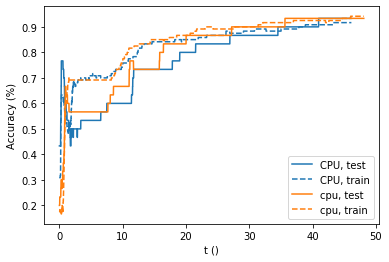

In [16]:
# (fluff) Get color order
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig1, ax1 = plt.subplots()
# CPU training
ax1.plot(t_list_cpu, acc_test_cpu, color=cycle[0], label='CPU, test')
ax1.plot(t_list_cpu, acc_train_cpu, '--', color=cycle[0], label='CPU, train')
# GPU training
ax1.plot(t_list_gpu, acc_test_gpu, color=cycle[1], label='{}, test'.format(device))
ax1.plot(t_list_gpu, acc_train_gpu, '--', color=cycle[1], label='{}, train'.format(device))
# Fluff
ax1.set(xlabel='t ()', ylabel='Accuracy (%)')
ax1.legend()
plt.show()